<a href="https://colab.research.google.com/github/signofcommunication/Tugas-Matana-University/blob/master/Deteksi_Jawaban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install opencv-python matplotlib
from google.colab import files
import cv2, numpy as np, matplotlib.pyplot as plt
from collections import Counter

Saving kertas 2.jpg to kertas 2.jpg


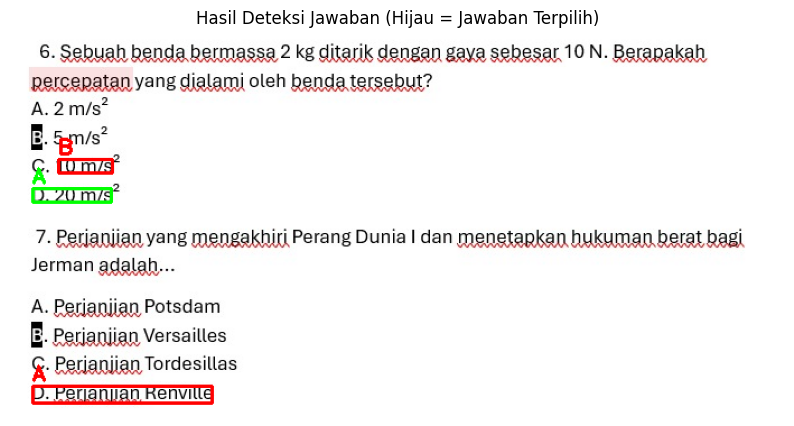


=== HASIL DETEKSI JAWABAN (v5 – Aman + Akurat) ===
Pertanyaan 1 : A

=== TOTAL ===
A : 1


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# === Upload file gambar lembar jawaban ===
uploaded = files.upload()
filename = next(iter(uploaded))
img = cv2.imread(filename)

# === Pra-proses ===
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Tambah kontras biar area hitam makin gelap
gray = cv2.convertScaleAbs(gray, alpha=2.2, beta=-70)

# Adaptive threshold (lebih tajam)
thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 25, 10
)

# Bersihkan noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# === Temukan kontur area hitam ===
cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
h, w = gray.shape

bubbles = []
for c in cnts:
    x, y, cw, ch = cv2.boundingRect(c)
    area = cw * ch
    if (w*h)*0.00005 < area < (w*h)*0.05 and cw < w*0.3:
        bubbles.append((x, y, cw, ch))

if len(bubbles) == 0:
    print("❌ Tidak ada area hitam terdeteksi. Periksa kontras gambar.")
else:
    # === Sortir berdasarkan posisi vertikal ===
    bubbles = sorted(bubbles, key=lambda b: (b[1], b[0]))

    # === Grouping per baris ===
    rows = []
    current_row = [bubbles[0]]
    for b in bubbles[1:]:
        if abs(b[1] - current_row[-1][1]) < 90:  # toleransi antar baris
            current_row.append(b)
        else:
            rows.append(sorted(current_row, key=lambda x: x[0]))
            current_row = [b]
    rows.append(sorted(current_row, key=lambda x: x[0]))

    answers = {}
    all_letters = ['A', 'B', 'C', 'D', 'E']  # fleksibel sampai E
    counts = {l: 0 for l in all_letters}

    # === Deteksi jawaban tiap baris ===
    for i, row in enumerate(rows, start=1):
        if len(row) < 2:
            continue  # skip kalau cuma 1 blok

        # Ambil hanya 4-5 kontur kiri pertama (hindari noise jauh di kanan)
        row_sorted = sorted(row, key=lambda x: x[0])[:5]
        letters = all_letters[:len(row_sorted)]

        dark_ratios = []
        for (x, y, cw, ch) in row_sorted:
            roi = gray[y:y+ch, x:x+cw]
            _, bin_roi = cv2.threshold(roi, 100, 255, cv2.THRESH_BINARY_INV)
            dark_ratio = cv2.countNonZero(bin_roi) / (cw * ch)
            dark_ratios.append(dark_ratio)

        idx = int(np.argmax(dark_ratios))
        ans = letters[idx] if idx < len(letters) else '?'
        answers[i] = ans
        if ans in counts:
            counts[ans] += 1

    # === Visualisasi hasil ===
    vis = img.copy()
    for i, row in enumerate(rows, start=1):
        row_sorted = sorted(row, key=lambda x: x[0])[:5]
        letters = all_letters[:len(row_sorted)]

        for j, (x, y, cw, ch) in enumerate(row_sorted):
            color = (0, 255, 0) if answers.get(i) == letters[j] else (0, 0, 255)
            cv2.rectangle(vis, (x, y), (x+cw, y+ch), color, 2)
            cv2.putText(vis, letters[j], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    plt.figure(figsize=(10, 12))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Hasil Deteksi Jawaban (Hijau = Jawaban Terpilih)")
    plt.axis('off')
    plt.show()

    # === Cetak hasil akhir ===
    print("\n=== HASIL DETEKSI JAWABAN (v5 – Aman + Akurat) ===")
    for i, ans in answers.items():
        print(f"Pertanyaan {i} : {ans}")

    print("\n=== TOTAL ===")
    for k, v in counts.items():
        if v > 0:
            print(f"{k} : {v}")
